In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Hive:
    """
    To model the fluctuating population of a bee hive throughtout time. Our function f
    should be a function that recieves a day of the year and outputs the population 
    numbers for drones and worker bees of the hive at that time of year. We always assume 
    the hive has 1 queen bee.
    """
    
    def __init__(self,f,day=None):
        self.f = f
        self.day = day % 365
        self.queen = 1
        self.drones = 0
        self.workers = 0
    
    def drone(self,num=None):
        if num != None:
            self.drones += num
        else:
            self.drones += 1
        
    def worker(self,num=None):
        if num != None:
            self.workers += num
        else:
            self.workers += 1
            
    def populate(self, day = None):
        if day != None:
            self.day = day
        if self.day == None:
            raise KeyError("No day provided")
        self.drones, self.workers = self.f(self.day)

In [3]:
def f(day):
    """
    An altered sine function with highest population occuring
    at the start of July, and lowest population occuring at 
    the end of December. We assume a population loss of 50% 
    in the winter.
    """
    pop = lambda day: .25*np.sin(2*np.pi/365*(day+275)) +.75
    num_bees = 30000*pop(day)
    workers = int(num_bees*.98)
    drones = int(num_bees - workers)
    return drones,workers

In [4]:
def dayOfYear(date):
    days = [0,31,28,31,30,31,30,31,31,30,31,30,31]
    d = list(map(int,date.split("-")))
    for i in range(1,len(days)):
         days[i]+=days[i-1]
    return days[d[0]-1]+d[1]-1

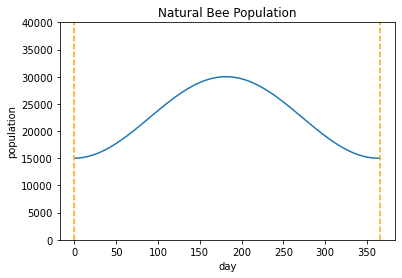

In [5]:
num_years = 1
day_domain = np.arange(1, 365*num_years+1)
pop_list = []
for day in day_domain:
    drones, workers = f(day)
    population = drones + workers
    pop_list.append(population)

plt.plot(day_domain, pop_list)
for i in range(num_years+1):
    plt.axvline(x=365*(i), linestyle='--', color='orange')
plt.ylim(0, 40000)
plt.xlabel('day')
plt.ylabel('population')
plt.title('Natural Bee Population')
plt.show()

### Assumptions
 - 30% of the workforce is foragers who go out of the hive every day
 - For now, I'm just going to consider acute toxicity
 - This is not currently backed by data, but I'm going to assume exposure to nontoxic, slightly toxic, moderately toxic, and highly toxic pesticides leads respectively to <100, 300, 700, and 1000 being killed per day
 - The bees forage from March to November
 
### Questions
 - What is the percent chance that a bee brings a pesticide back to the hive?
 - How does bringing a pesticide back to the hive affect things?
 - Does our sine wave function take into account the fact that less bees will be born if less bees are alive? Actually, is this even true? This might not be true because the queen is disconnected from the rest of the workers.

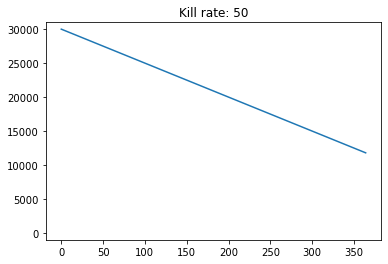

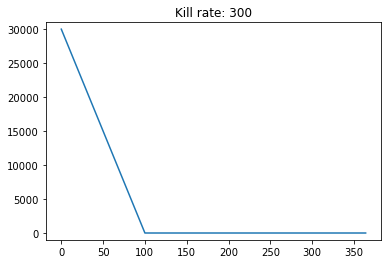

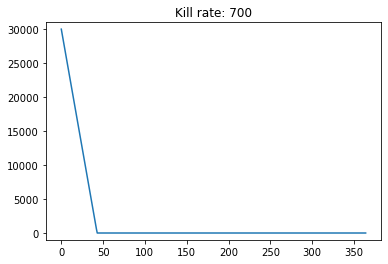

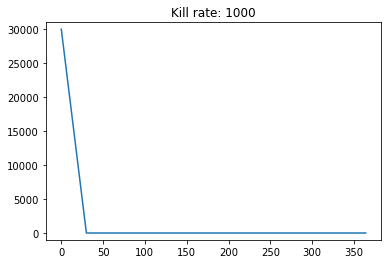

In [6]:
# I'm not dealing with the sin wave right now.

for kill_rate in [50, 300, 700, 1000]:
    initial_pop = 30000
    pop_per_day = [initial_pop]
    g = lambda x: x - kill_rate
    prev_pop = initial_pop
    for i in range(364):
        curr_pop = g(prev_pop)
        if curr_pop <= 0:
            curr_pop = 0
        pop_per_day.append(curr_pop)
        prev_pop = curr_pop

    plt.plot(np.arange(365), pop_per_day)
    plt.ylim(-1000, 31000)
    plt.title(f'Kill rate: {kill_rate}')
    plt.show()

### SIR just for pesticides

### Assumptions
 - The lifespan of a bee in the summer is 40 days
 - The last 1/4 of a bee's life is spent foraging
 - Assuming no birth rate. This is a pretty bad assumption
 - Also the numbers used for toxicity are totally made up

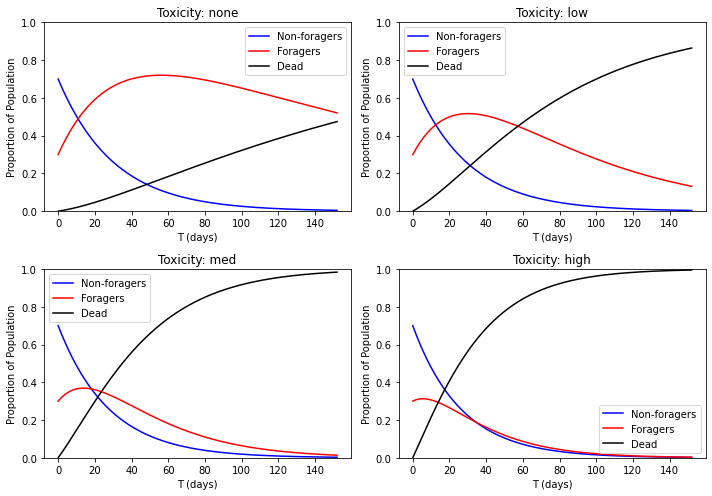

In [7]:
from scipy.integrate import solve_ivp

def ode_maker(tox):
    toxicity_levels = {'high': (.05, .005),
                       'med': (.03, .003),
                       'low': (.01, .001),
                       'none': (0, 0)}
    b = 0 # birth rate
    c = 0.033 # prop of workers becoming foragers
    d = .005 # normal death rate of foragers
    p = toxicity_levels[tox][0] # prop of foragers poisoned from contact
    q = toxicity_levels[tox][1] # prop of bees dying from poisoned food. I had wanted to make the amount of poisoned food a function of the number of foragers and then use that number to determine bees dying from poisoned food, but alas.
    
    def ode(t, y):
        W = y[0] # non-forager workers
        F = y[1] # foragers
        D = y[2] # ded bbeess
        return np.array([b + -c*W - q*W,
                         c*W - d*F - p*F - q*F,
                         d*F + q*W + p*F + q*F])
    return ode

# Set up initial values
total_hive_population = 30000
worker_bees = int(.98*30000)
non_foragers = worker_bees * .7
foragers = worker_bees * .3
dead = 0
y0 = np.array([non_foragers, foragers, dead]) / worker_bees
t0 = 0
tf = 153 # 153 is the number of days between May and October, when bees would be out foraging

for i, toxicity in enumerate(['none', 'low', 'med', 'high']):
    built_ode = ode_maker(toxicity)

    # Calculate ODE
    sol = solve_ivp(built_ode, (t0, tf), y0, t_eval=np.arange(tf))
    
    # Plot results
    plt.subplot(2, 2, i+1)
    plt.plot(sol.t, sol.y[0], label='Non-foragers', color='blue')
    plt.plot(sol.t, sol.y[1], label='Foragers', color='red')
    plt.plot(sol.t, sol.y[2], label='Dead', color='black')
    plt.ylim(0, 1)
    plt.ylabel('Proportion of Population')
    plt.xlabel('T (days)')
    plt.legend()
    plt.title('Toxicity: {}'.format(toxicity))
plt.gcf().set_size_inches(10, 7)
plt.tight_layout()
plt.show()
